In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
Batch_size= 32
Image_size = 256
Channels =3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Tomato deseas',
    seed=123,
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 256, 256, 3)
(32,)


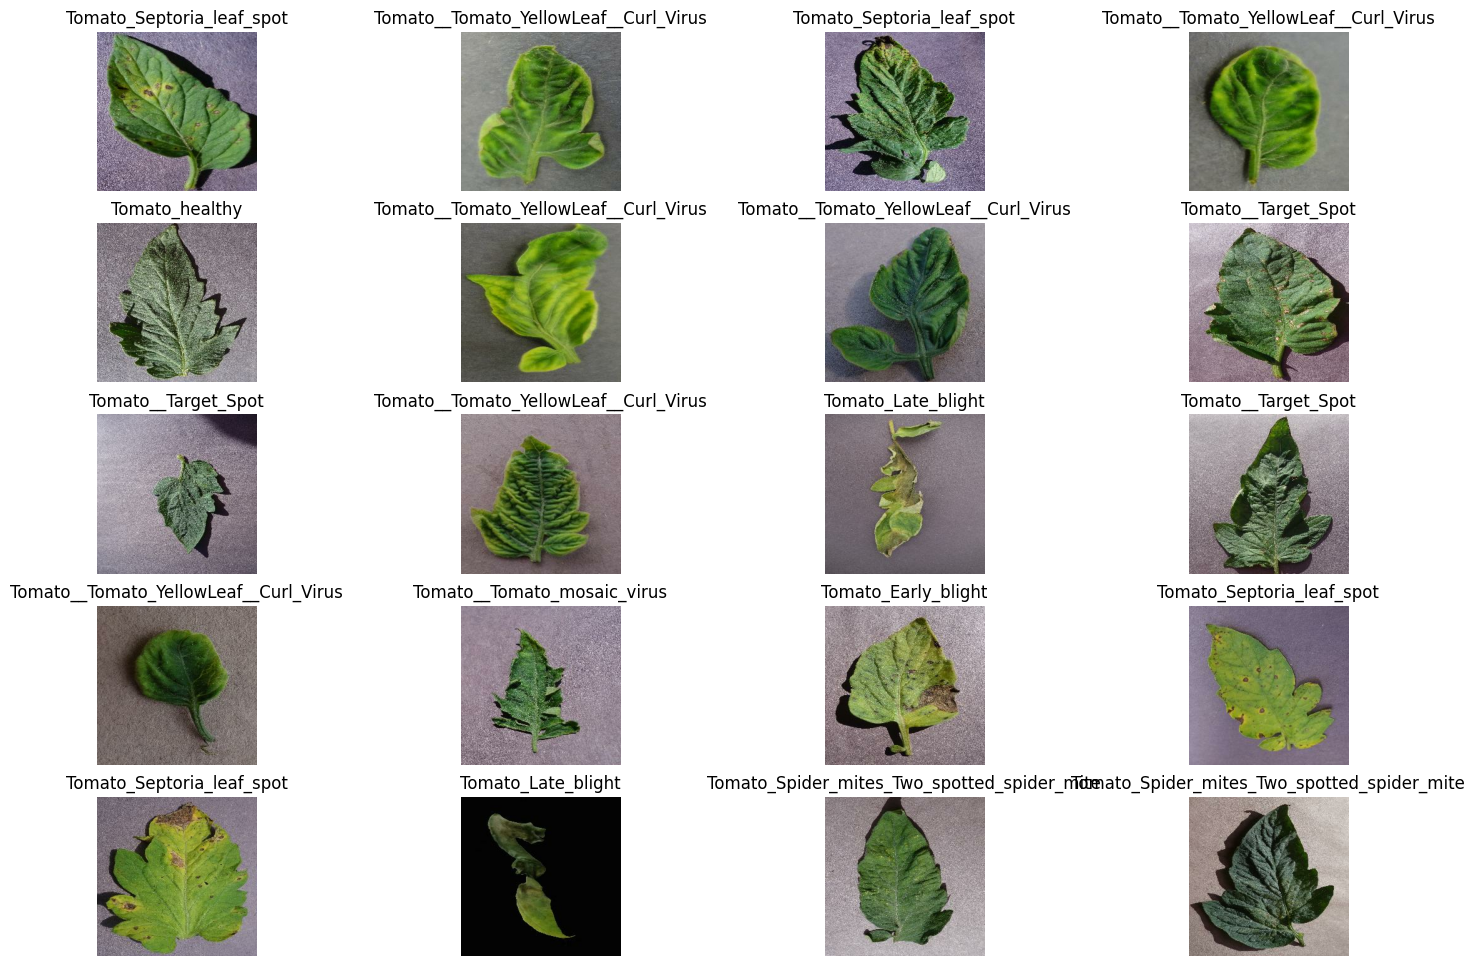

In [9]:
plt.figure(figsize=(18,12))
for image,label in dataset.take(1):
  for i in range(20):
    ax=plt.subplot(5,4,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')


In [10]:
len(dataset)

501

In [11]:
train_size =0.8
len(dataset)*train_size

400.8

In [12]:
train_ds= dataset.take(400)
len(train_ds)

400

In [13]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [14]:
val_size =0.1
len(dataset)*val_size

50.1

In [15]:
val_ds =test_ds.take(50)
len(val_ds)

50

In [16]:
test_ds =test_ds.skip(50)
len(test_ds)

51

In [17]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert (train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [19]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

400
50
51


In [20]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras import models, layers
resize_and_rescale =tf.keras.Sequential([
    layers.Resizing(Image_size,Image_size),
    layers.Rescaling(1./255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [23]:
train_ds = train_ds.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (Batch_size,Image_size,Image_size,Channels)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Flatten(),

    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 2, 2, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,458 (720.54 KB)

 Trainable params: 184,330 (720.04 KB)

 Non-trainable params: 128 (512.00 B)

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']

)

In [27]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs = 35
)

Epoch 1/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 443s 953ms/step - accuracy: 0.4013 - loss: 1.6821 - val_accuracy: 0.3149 - val_loss: 4.0479
Epoch 2/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 354s 885ms/step - accuracy: 0.6880 - loss: 0.8653 - val_accuracy: 0.4228 - val_loss: 2.2598
Epoch 3/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 351s 877ms/step - accuracy: 0.7654 - loss: 0.6539 - val_accuracy: 0.8460 - val_loss: 0.4418
Epoch 4/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 350s 875ms/step - accuracy: 0.8070 - loss: 0.5320 - val_accuracy: 0.7345 - val_loss: 0.8195
Epoch 5/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 346s 864ms/step - accuracy: 0.8409 - loss: 0.4475 - val_accuracy: 0.5537 - val_loss: 2.1291
Epoch 6/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 348s 869ms/step - accuracy: 0.8502 - loss: 0.4315 - val_accuracy: 0.5250 - val_loss: 2.7388
Epoch 7/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 344s 859ms/step - accuracy: 0.8697 - loss: 0.3763 - val_accuracy: 0.8372 - val_loss: 0.4939
Epoch 8/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 338s 846ms/step - accuracy: 0.8829 -

In [28]:
scores = model.evaluate(test_ds)

400/400 ━━━━━━━━━━━━━━━━━━━━ 86s 216ms/step - accuracy: 0.9330 - loss: 0.2167


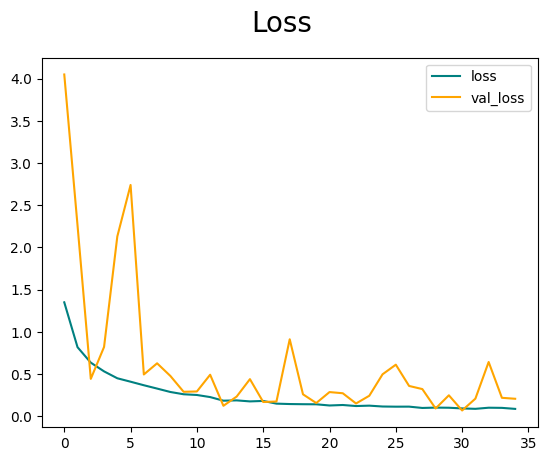

In [31]:
fig = plt.figure()
plt.plot(history.history['loss'],color='teal',label='loss')
plt.plot(history.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend()
plt.show()

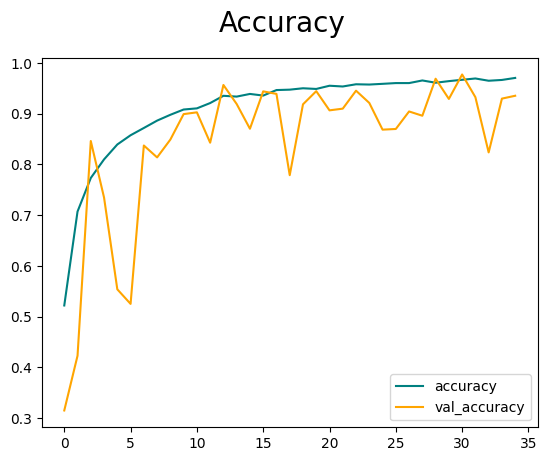

In [32]:
fig = plt.figure()
plt.plot(history.history['accuracy'],color='teal',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend()
plt.show()

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
predicted label: Tomato_Septoria_leaf_spot


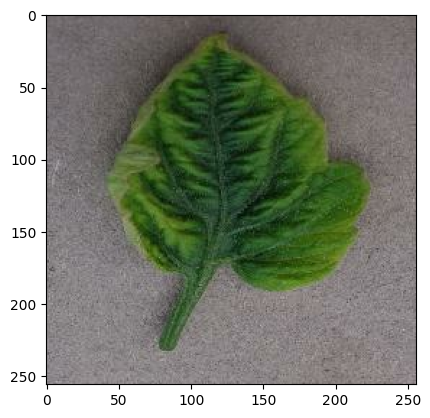

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[7].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


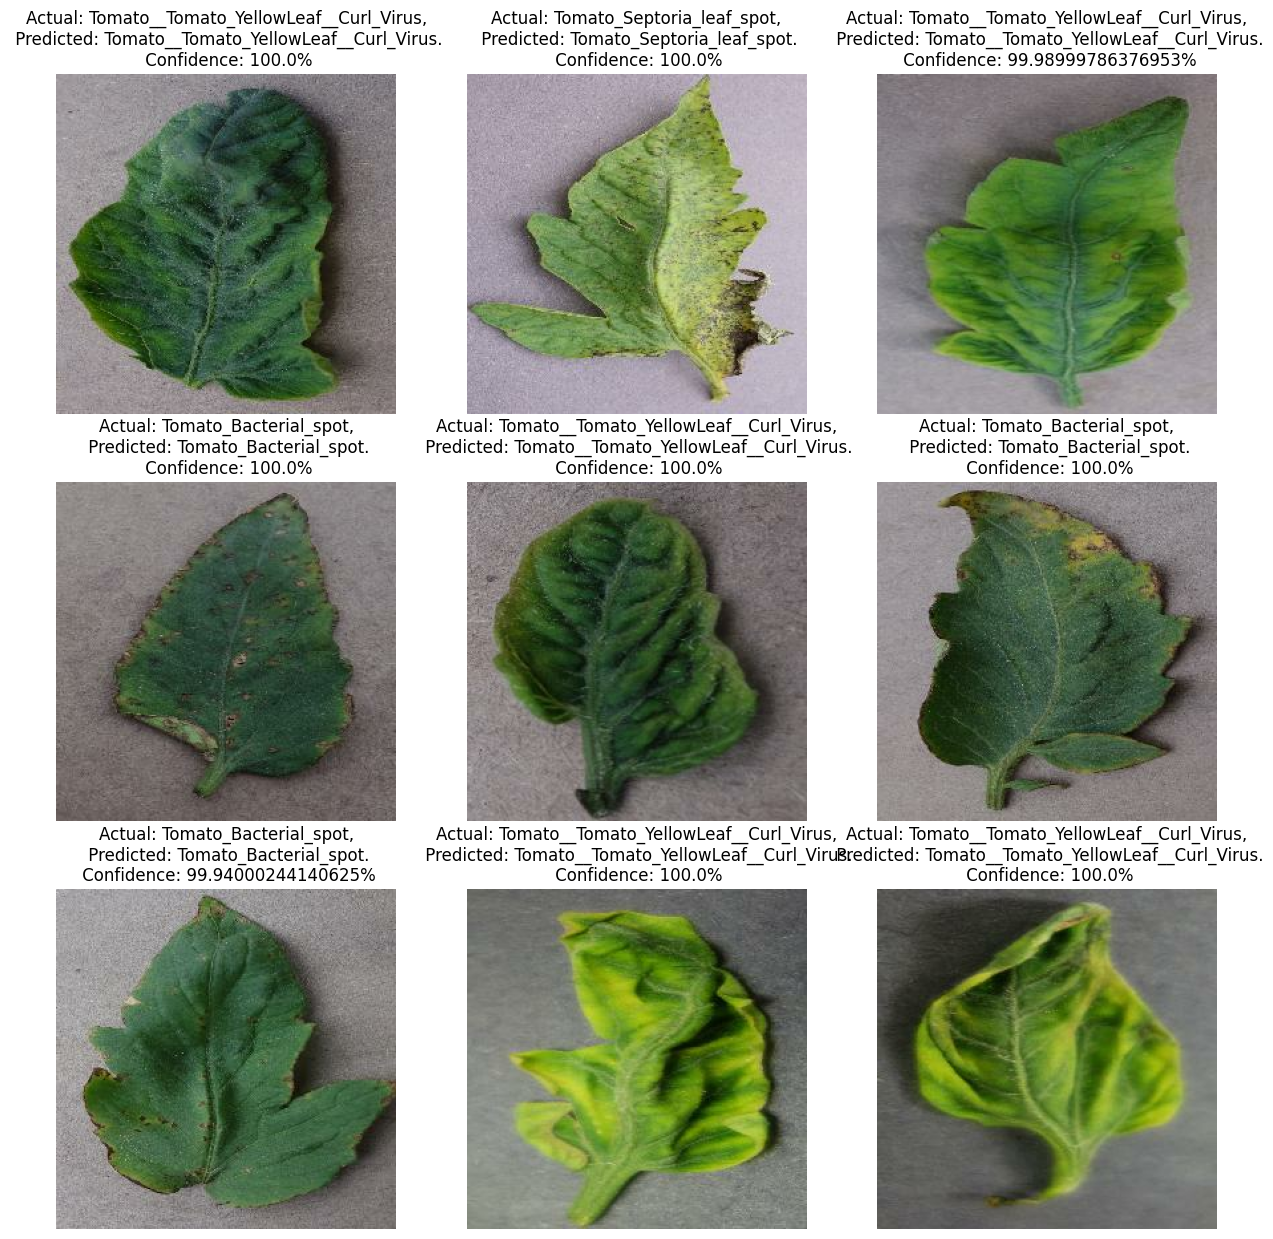

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [37]:
import numpy as np

precision.reset_state()
recall.reset_state()
accuracy.reset_state()

for batch in test_ds.as_numpy_iterator():
    X, y = batch

    yhat = model.predict(X)

    yhat_classes = np.argmax(yhat, axis=1)

    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)
    accuracy.update_state(y, yhat_classes)

print("Precision:", precision.result().numpy())
print("Recall:", recall.result().numpy())
print("Accuracy:", accuracy.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save("model.keras")